# 2.0 Baseline (TF-IDF + Logistic Regression)

This notebook:
- Loads fixed 80/10/10 splits from `data/splits/`
- Trains TF-IDF + Logistic Regression on train, tunes on val, reports on test
- Saves:
  - `results/tables/baseline_metrics.csv`
  - `results/preds/baseline_<dataset>_test.jsonl`
  - `results/figures/baseline_<dataset>_cm.png`, `baseline_<dataset>_reliability.png`
  - `models/baseline_<dataset>_vectorizer.joblib`, `models/baseline_<dataset>_lr.joblib`

In [7]:
# Config & paths
import json, os, yaml, random, platform, sys
from pathlib import Path

DEFAULT_CFG = {
    "seed": 42,
    "output_tables": "results/tables",
    "output_figures": "results/figures",
    "output_preds": "results/preds",
    "output_models": "models",
    # Vectorizer/Model defaults (can move to configs/baseline.yaml later)
    "tfidf": {"ngram_range": [1, 2], "min_df": 2, "max_df": 0.98, "max_features": 200000},
    "logreg": {"C": 1.0, "solver": "liblinear", "max_iter": 200},
}

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "configs").exists() or (p / "src").exists() or (p / ".git").exists():
            return p
    return start

NOTEBOOK_CWD = Path.cwd()
ROOT = find_repo_root(NOTEBOOK_CWD)
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

CFG_PATH = ROOT / "configs" / "baseline.yaml"
if CFG_PATH.exists():
    with open(CFG_PATH, "r") as f:
        CFG = {**DEFAULT_CFG, **yaml.safe_load(f)}
else:
    print("configs/baseline.yaml not found — using defaults.")
    CFG = DEFAULT_CFG

DIR_TABLES = ROOT / CFG["output_tables"]
DIR_FIGS   = ROOT / CFG["output_figures"]
DIR_PREDS  = ROOT / CFG["output_preds"]
DIR_MODELS = ROOT / CFG["output_models"]
for p in (DIR_TABLES, DIR_FIGS, DIR_PREDS, DIR_MODELS):
    p.mkdir(parents=True, exist_ok=True)

DIR_SPLITS = ROOT / "data" / "splits"

print("Python:", sys.version)
print("ROOT:", ROOT)
print("Tables:", DIR_TABLES)
print("Figures:", DIR_FIGS)
print("Preds:", DIR_PREDS)
print("Models:", DIR_MODELS)
print("Splits:", DIR_SPLITS)

configs/baseline.yaml not found — using defaults.
Python: 3.13.2 (v3.13.2:4f8bb3947cf, Feb  4 2025, 11:51:10) [Clang 15.0.0 (clang-1500.3.9.4)]
ROOT: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project
Tables: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/results/tables
Figures: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/results/figures
Preds: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/results/preds
Models: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/models
Splits: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/data/splits


In [8]:
# Imports & utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json, joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

RNG = np.random.default_rng(CFG["seed"])

def brier_score(y_true, prob_pos):
    return brier_score_loss(y_true, prob_pos)

def save_jsonl(rows, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

In [9]:
# %% Load datasets
from datasets import load_dataset

def to_df(ds, text_key="text", label_key="label"):
    return pd.DataFrame({"text": ds[text_key], "label": ds[label_key]})

ds_imdb = load_dataset("imdb")
imdb_train = to_df(ds_imdb["train"])
imdb_test  = to_df(ds_imdb["test"])
imdb_full  = pd.concat([imdb_train, imdb_test], ignore_index=True)

ds_rt   = load_dataset("rotten_tomatoes")
rt_train = to_df(ds_rt["train"])
rt_val   = to_df(ds_rt["validation"])
rt_test  = to_df(ds_rt["test"])
rt_full  = pd.concat([rt_train, rt_val, rt_test], ignore_index=True)

print("IMDB full:", imdb_full.shape, "| RT full:", rt_full.shape)

IMDB full: (50000, 2) | RT full: (10662, 2)


In [10]:
# Load fixed split indices
with open(DIR_SPLITS / "imdb_indices.json", "r") as f:
    imdb_idx = json.load(f)
with open(DIR_SPLITS / "rt_indices.json", "r") as f:
    rt_idx = json.load(f)

def split_by_indices(df: pd.DataFrame, idx_dict: dict):
    tr = df.iloc[idx_dict["train"]].reset_index(drop=True)
    va = df.iloc[idx_dict["val"]].reset_index(drop=True)
    te = df.iloc[idx_dict["test"]].reset_index(drop=True)
    return tr, va, te

imdb_tr, imdb_va, imdb_te = split_by_indices(imdb_full, imdb_idx)
rt_tr,   rt_va,   rt_te   = split_by_indices(rt_full,   rt_idx)

for name, (tr, va, te) in {
    "imdb": (imdb_tr, imdb_va, imdb_te),
    "rt":   (rt_tr, rt_va, rt_te),
}.items():
    print(f"{name.upper():4s} -> train={len(tr):5d}  val={len(va):5d}  test={len(te):5d}")

IMDB -> train=40000  val= 5000  test= 5000
RT   -> train= 8529  val= 1066  test= 1067


In [13]:
# Train/eval pipeline
def run_baseline(train_df, val_df, test_df, dataset_tag: str):
    # Vectorizer
    tv_cfg = CFG["tfidf"]
    vect = TfidfVectorizer(
        ngram_range=tuple(tv_cfg["ngram_range"]),
        min_df=tv_cfg["min_df"],
        max_df=tv_cfg["max_df"],
        max_features=tv_cfg["max_features"],
    )
    X_tr = vect.fit_transform(train_df["text"])
    y_tr = train_df["label"].values

    # Simple C sweep using validation for selection
    lr_cfg = CFG["logreg"].copy()
    Cs = [0.25, 0.5, 1.0, 2.0, 4.0]
    best = None
    for C in Cs:
        clf = LogisticRegression(C=C, solver=lr_cfg["solver"], max_iter=lr_cfg["max_iter"], random_state=CFG["seed"])
        clf.fit(X_tr, y_tr)
        X_va = vect.transform(val_df["text"])
        y_va = val_df["label"].values
        prob_va = clf.predict_proba(X_va)[:, 1]
        preds_va = (prob_va >= 0.5).astype(int)
        f1_va = f1_score(y_va, preds_va, average="macro")
        if (best is None) or (f1_va > best["f1_va"]):
            best = {"C": C, "clf": clf, "f1_va": f1_va}

    # Refit on train+val with best C
    C_best = best["C"]
    clf = LogisticRegression(C=C_best, solver=lr_cfg["solver"], max_iter=lr_cfg["max_iter"], random_state=CFG["seed"])
    X_trva = vect.fit_transform(pd.concat([train_df["text"], val_df["text"]], ignore_index=True))
    y_trva = pd.concat([train_df["label"], val_df["label"]], ignore_index=True).values
    clf.fit(X_trva, y_trva)

    # Evaluate on test
    X_te = vect.transform(test_df["text"])
    y_te = test_df["label"].values
    prob_te = clf.predict_proba(X_te)[:, 1]
    pred_te = (prob_te >= 0.5).astype(int)

    acc  = accuracy_score(y_te, pred_te)
    f1m  = f1_score(y_te, pred_te, average="macro")
    brier = brier_score(y_te, prob_te)

    # Save predictions
    rows = [{"text": t, "label": int(y), "prob_pos": float(p), "pred": int(h)} 
            for t, y, p, h in zip(test_df["text"], y_te, prob_te, pred_te)]
    save_jsonl(rows, DIR_PREDS / f"baseline_{dataset_tag}_test.jsonl")

    # Save artifacts
    joblib.dump(vect, DIR_MODELS / f"baseline_{dataset_tag}_vectorizer.joblib")
    joblib.dump(clf,  DIR_MODELS / f"baseline_{dataset_tag}_lr.joblib")

    # Confusion matrix
    cm = confusion_matrix(y_te, pred_te, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["neg","pos"])
    disp.plot(values_format="d")
    plt.title(f"Baseline Confusion Matrix: {dataset_tag.upper()}")
    cm_path = DIR_FIGS / f"baseline_{dataset_tag}_cm.png"
    plt.tight_layout(); plt.savefig(cm_path, dpi=150); plt.show()

    # Reliability / calibration curve
    fracs, means = calibration_curve(y_te, prob_te, n_bins=10, strategy="quantile")
    plt.figure(figsize=(4.8, 4))
    plt.plot([0,1],[0,1], linestyle="--")
    plt.plot(fracs, means, marker="o")
    plt.xlabel("Predicted probability (bin avg)")
    plt.ylabel("Empirical positive rate")
    plt.title(f"Reliability Curve: {dataset_tag.upper()}")
    rel_path = DIR_FIGS / f"baseline_{dataset_tag}_reliability.png"
    plt.tight_layout(); plt.savefig(rel_path, dpi=150); plt.show()

    metrics = {
        "dataset": dataset_tag,
        "C_best": C_best,
        "acc": acc,
        "macro_f1": f1m,
        "brier": brier,
        "n_test": len(test_df),
    }
    return metrics

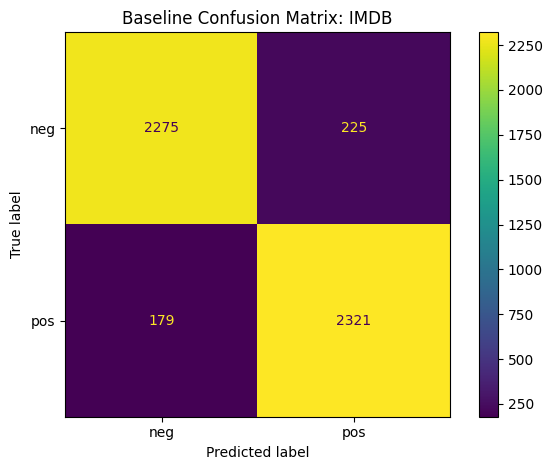

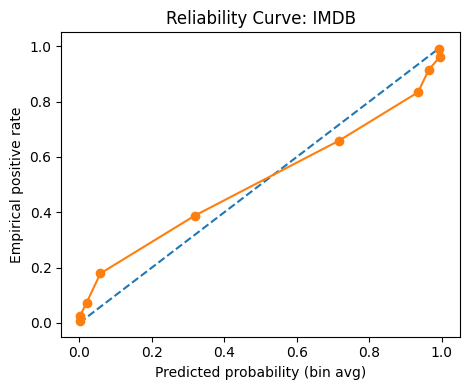

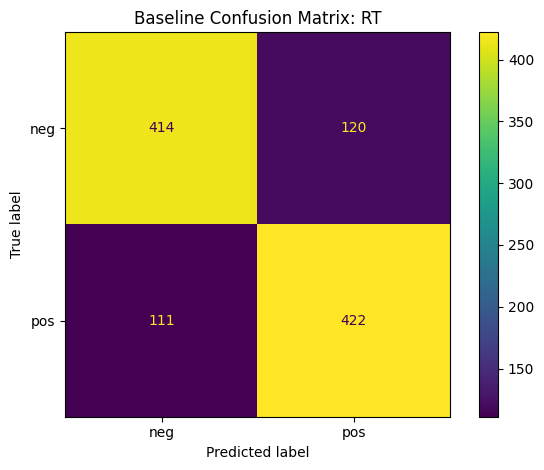

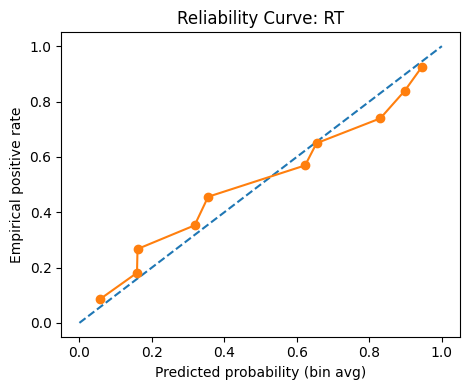

(  dataset  C_best       acc  macro_f1     brier  n_test
 0    imdb     4.0  0.919200  0.919193  0.063290    5000
 1      rt     4.0  0.783505  0.783493  0.154279    1067,
 PosixPath('/Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/results/tables/baseline_metrics.csv'))

In [14]:
# Run & collect metrics
metrics = []
metrics.append(run_baseline(imdb_tr, imdb_va, imdb_te, dataset_tag="imdb"))
metrics.append(run_baseline(rt_tr,   rt_va,   rt_te,   dataset_tag="rt"))

mtx = pd.DataFrame(metrics)
mtx_path = DIR_TABLES / "baseline_metrics.csv"
mtx.to_csv(mtx_path, index=False)
mtx, mtx_path